In [1]:
## NEW PYTHON CAPSTONE NOTEBOOK FOR GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score

#keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Flatten, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

#convolutional keras imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

#suppress FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
## uncomment this cell if using google colab
##import the dataset to google colab

#from google.colab import files
#uploaded = files.upload()

Saving compressed-class-separated.pkl to compressed-class-separated.pkl


In [ ]:
##uncomment if using google colab to check that gpu is enabled for modeling
## used in google colab to see if a gpu is being used

#import tensorflow as tf
#tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
##read in the pickle file from google colab
#protein = pd.read_pickle('/content/compressed-class-separated.pkl', compression = 'gzip')
#protein.head()

,Gene ontology (molecular function),Sequence,Length,Organism,Protein names,class
0,rRNA binding [GO:0019843]; structural constitu...,MNVILLDKIANLGSLGDQVSVKSGYARNFLFPQGKAVPATKSNVDL...,150,Idiomarina loihiensis (strain ATCC BAA-735 / D...,50S ribosomal protein L9,1
1,rRNA binding [GO:0019843]; structural constitu...,MQLYDFYKKNVLIKLKNKFNYKSIMQVPKIEKITLNMGVGKASFDK...,178,Wigglesworthia glossinidia brevipalpis,50S ribosomal protein L5,1
2,rRNA binding [GO:0019843]; structural constitu...,MELKLLNDQGQAASNVAAPDTIFGRDYNEALIHQVVVAYQANARSG...,206,Janthinobacterium sp. (strain Marseille) (Mini...,50S ribosomal protein L4,1
3,rRNA binding [GO:0019843]; structural constitu...,MNVILLDKIANLGNLGDQVAVKAGYARNYLLPQGKAVVANESNVKV...,150,Shewanella sp. (strain MR-7),50S ribosomal protein L9,1
4,rRNA binding [GO:0019843]; structural constitu...,MSRVAKAPVNIPAGVEVKLDGQLLTVKGKNGELSRKIHESVEVKQD...,177,Haemophilus influenzae (strain PittGG),50S ribosomal protein L6,1


In [ ]:
#reading in the pickle file in jupyter lab
protein = pd.read_pickle('data/compressed-class-separated.pkl', compression = 'gzip')

In [ ]:
#drop the rows that aren't needed for modeling here
#only want sequence and class values
protein = protein.drop(columns = ['Gene ontology (molecular function)', 'Length', 'Organism', 'Protein names'])
protein.head(2)

,Sequence,class
0,MNVILLDKIANLGSLGDQVSVKSGYARNFLFPQGKAVPATKSNVDL...,1
1,MQLYDFYKKNVLIKLKNKFNYKSIMQVPKIEKITLNMGVGKASFDK...,1


## Preprocessing the Data

#### Function for Making Each Amino Acid Abbreviation a "word"

In [ ]:
## make each single letter amino acid it's own "word" for tokenizing
def make_words(sequence):
    
    """
    argument: amino acid sequence in single letter code/abbreviation
    output: input amino acid sequence with spaces between each single letter code
    """
    
    
    #instantiate empty string to concat amino acids to
    space_seq = ''
    
    #for loop to loop over each amino acid in the sequence and add it into the 
    #string with a space afterwards
    for char in sequence:
        space_seq += char
        space_seq += " "
    #remove the space at end of the new string
    return space_seq[:-1] 

In [ ]:
#apply the function to the sequence column of the dataframe
protein['Sequence'] = protein['Sequence'].apply(lambda x: make_words(x))

In [ ]:
#more views to make sure application of make_words occurred correctly
protein.head(3)

,Sequence,class
0,M N V I L L D K I A N L G S L G D Q V S V K S ...,1
1,M Q L Y D F Y K K N V L I K L K N K F N Y K S ...,1
2,M E L K L L N D Q G Q A A S N V A A P D T I F ...,1


#### Setting up X and y for training

To be able to keep the Google Colab session within the RAM allotment, the ATP class was reduced to 20,000 observations from the original 64,687. 

In [ ]:
#the original shape of the protein data
protein.shape

(130981, 2)

In [ ]:
#grabbing the atp class from the data
atp_class = protein[protein['class']==3]

#sample the atp class for only 20,000 observations
atp_class = atp_class.sample(n = 20_000)

In [ ]:
#remove atp class from protein dataframe
no_atp_df = protein[protein['class']!=3]

In [ ]:
#make the protein dataframe once more with 40k~ less atp binding values -- so RAM doesn't fail for the next code
#reassigned the protein variable to the new data
protein = pd.concat([atp_class,no_atp_df])

In [ ]:
#set up the X and y values for the recurrent neural net
#X and y type is series
X = protein['Sequence']
y = protein['class']

In [ ]:
#train/test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 18)

In [ ]:
X_train.shape

(64720,)

In [ ]:
X_test.shape

(21574,)

In [ ]:
##oversample the minority classes
#make X and y into an array
X_train = X_train.to_numpy().reshape(-1,1)
y_train = y_train.to_numpy().reshape(-1,1)

#oversample the minority class
oversample = RandomOverSampler(sampling_strategy= 'auto')
#over sample the classes here
X_train_oversamp, y_train_oversamp = oversample.fit_resample(X_train, y_train.ravel())

#make the X values back into a series
X_train = pd.Series(X_train_oversamp.tolist()).str.get(0)
#make the y values back into a series
y_train = pd.Series(y_train_oversamp.tolist())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train.shape

(147976,)

In [ ]:
#as there are only 21 "words"/1-letter amino acids we want to keep all of these
#default tokenizer splits on a white space
tokenizer = Tokenizer(21)

In [ ]:
#fit the tokenizer to the training data so it can learn the 21 "words"
tokenizer.fit_on_texts(X_train)

In [ ]:
#make the 21 "words" into sequences
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#to make the sequences all the same length pad the sequences 
x_train = pad_sequences(x_train, maxlen = 18_000)
x_test = pad_sequences(x_test, maxlen = 18_000)

In [ ]:
#observe the oversampled spread of the training classes
y_train.value_counts(normalize = True)

8    0.125
7    0.125
6    0.125
5    0.125
4    0.125
3    0.125
2    0.125
1    0.125
dtype: float64

#### Categorize Class Values for Neural Network 

In [ ]:
#make the y categorical
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [ ]:
#print the shapes of the training and testing data
print(f'The shape of x train is: {x_train.shape}.')
print(f'The shape of x test is: {x_test.shape}.')
print(f'The shape of y train is: {y_train.shape}.')
print(f'The shape of y test is: {y_test.shape}.')

The shape of x train is: (147976, 18000).
The shape of x test is: (21574, 18000).
The shape of y train is: (147976, 8).
The shape of y test is: (21574, 8).


## Oversampled RNN Multi-Label Classifier 1 - Account for Class Overlap

In [ ]:
#create the new model architecture for the multi-label classifier
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64, input_length = x_train.shape[1]))

#add the convolutional layer
model.add(Conv1D(128,32, activation = 'relu'))
model.add(MaxPooling1D(6))

#add second convolutional layer and GRU layer
model.add(Conv1D(64,24, activation = 'relu'))
model.add(Bidirectional(GRU(64)))
model.add(Dense(120, activation = 'relu'))
model.add(Dropout(rate = .2))
model.add(Dense(8, activation = 'sigmoid'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
579/579 [==============================] - 959s 2s/step - loss: 0.2639 - acc: 0.5048 - precision: 0.6519 - recall: 0.3491 - val_loss: 0.0861 - val_acc: 0.8630 - val_precision: 0.8859 - val_recall: 0.8380
Epoch 2/40
579/579 [==============================] - 946s 2s/step - loss: 0.0497 - acc: 0.9301 - precision: 0.9414 - recall: 0.9165 - val_loss: 0.0680 - val_acc: 0.9022 - val_precision: 0.9136 - val_recall: 0.8911
Epoch 3/40
579/579 [==============================] - 948s 2s/step - loss: 0.0219 - acc: 0.9719 - precision: 0.9748 - recall: 0.9676 - val_loss: 0.0490 - val_acc: 0.9359 - val_precision: 0.9453 - val_recall: 0.9270
Epoch 4/40
579/579 [==============================] - 949s 2s/step - loss: 0.0114 - acc: 0.9859 - precision: 0.9877 - recall: 0.9838 - val_loss: 0.0545 - val_acc: 0.9319 - val_precision: 0.9382 - val_recall: 0.9277
Epoch 5/40
579/579 [==============================] - 949s 2s/step - loss: 0.0071 - acc: 0.9919 - precision: 0.9924 - recall: 0.9906 - val_l

In [ ]:
#get the final model evaluations
model.evaluate(x_test,y_test)

675/675 [==============================] - 92s 137ms/step - loss: 0.0543 - acc: 0.9438 - precision: 0.9479 - recall: 0.9412


[0.054321061819791794,
 0.9438212513923645,
 0.9478597640991211,
 0.941225528717041]

### Oversampled Model 1 Interpretation

In the model above, the best model from the previous notebook was re-trained using the oversampled data. Without oversampled and balanced class numbers, this model scored 90.85% on balanced accuracy. Calculated below, the balanced accuracy of this score with balanced data is 92.2%. This told me that oversampling the minority classes of the data improved the performanced of the model. 

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model.predict(x_test)
preds = np.argmax(preds, axis=1)

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.99      0.99      0.99      4944
       DNA Binding       0.91      0.96      0.93      6286
       ATP Binding       0.93      0.91      0.92      5039
           Hormone       0.86      0.93      0.89       366
            GTPase       0.98      0.98      0.98      1390
NADH Dehydrogenase       0.99      0.97      0.98      1013
    Oxidoreductase       0.87      0.70      0.78       864
             Toxin       0.97      0.94      0.95      1672

          accuracy                           0.94     21574
         macro avg       0.94      0.92      0.93     21574
      weighted avg       0.94      0.94      0.94     21574



### Table Interpretation

The table above is the classification report for Oversampled Model 1. This report breaks down how well the model performed on predicting the individual classes in the testing data. Oversampled Model 1 has the best f1-score for each individual class seen so far. Compared to Model 6, the same neural network architecture without oversampled data, Oversampled Model 1 scored .14 points better on f1-score for the Oxidoreductase class and .9 points better on f1-score for the Hormone class. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.9220749835584425

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9432750284874386

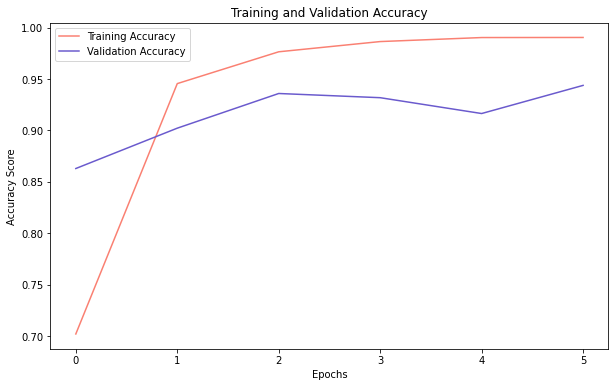

In [ ]:
#plot the graphs of the accuracy
plt.figure(figsize=(10,6))
plt.plot(hist_6.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_6.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend();

### Visualization Interpretation

The visualization above shows the accuracy for the training and testing/validation sets over the 6 epochs the neural network trained. As we can see the training accuracy increased over all of the epochs until approximately 99% accuracy. The testing/validation accuracy, while much more variable than the training accuracy, obtained a score of approximately 94.4%. 

## Oversampled RNN Model 2 - Accounts for Class Overlap

In [ ]:
#create the new model architecture for oversampled model 2
model_osamp = Sequential()

model_osamp.add(Embedding(input_dim = tokenizer.num_words, output_dim = 82, input_length = x_train.shape[1]))

#add the convolutional layer
model_osamp.add(Conv1D(164,36, activation = 'relu'))
model_osamp.add(MaxPooling1D(6))

#add second convolutional layer and GRU layer
model_osamp.add(Conv1D(48,24, activation = 'relu'))
model_osamp.add(Bidirectional(GRU(86)))
model_osamp.add(Dense(320, activation = 'relu'))
model_osamp.add(Dropout(rate = .2))
model_osamp.add(Dense(8, activation = 'sigmoid'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_osamp.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_osamp = model_osamp.fit(x_train, y_train, validation_data = (x_test, y_test),
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
579/579 [==============================] - 1616s 3s/step - loss: 0.2340 - acc: 0.5569 - precision: 0.7115 - recall: 0.4215 - val_loss: 0.1524 - val_acc: 0.7847 - val_precision: 0.8168 - val_recall: 0.7481
Epoch 2/40
579/579 [==============================] - 1602s 3s/step - loss: 0.0359 - acc: 0.9488 - precision: 0.9570 - recall: 0.9401 - val_loss: 0.0497 - val_acc: 0.9329 - val_precision: 0.9423 - val_recall: 0.9236
Epoch 3/40
579/579 [==============================] - 1598s 3s/step - loss: 0.0115 - acc: 0.9849 - precision: 0.9865 - recall: 0.9824 - val_loss: 0.0739 - val_acc: 0.9054 - val_precision: 0.9104 - val_recall: 0.9022
Epoch 4/40
579/579 [==============================] - 1597s 3s/step - loss: 0.0076 - acc: 0.9908 - precision: 0.9913 - recall: 0.9897 - val_loss: 0.0626 - val_acc: 0.9305 - val_precision: 0.9370 - val_recall: 0.9244
Epoch 5/40
579/579 [==============================] - 1599s 3s/step - loss: 0.0055 - acc: 0.9932 - precision: 0.9934 - recall: 0.9925 - 

In [ ]:
#get the final model evaluations
model_osamp.evaluate(x_test,y_test)

675/675 [==============================] - 105s 155ms/step - loss: 0.0729 - acc: 0.9291 - precision: 0.9301 - recall: 0.9291


[0.07286936789751053,
 0.9291276335716248,
 0.9300728440284729,
 0.9290813207626343]

### Model Interpretation

In Oversampled Model 2, the embedding dimensions, filter sizes of the convolutional layers, number of GRU nodes, etc. were manipulated in attempt to tune the model towards a better performance. Compared to Oversampled Model 1, this model performed worse, acheiving a balanced accuracy score of 90% and an f1-score of 92.8%. 

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model_osamp.predict(x_test)
preds = np.argmax(preds, axis=1)

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.99      0.99      0.99      4944
       DNA Binding       0.85      0.98      0.91      6286
       ATP Binding       0.95      0.85      0.90      5039
           Hormone       0.87      0.92      0.90       366
            GTPase       0.99      0.97      0.98      1390
NADH Dehydrogenase       0.99      0.97      0.98      1013
    Oxidoreductase       0.92      0.62      0.74       864
             Toxin       0.98      0.91      0.94      1672

          accuracy                           0.93     21574
         macro avg       0.94      0.90      0.92     21574
      weighted avg       0.93      0.93      0.93     21574



### Table Interpretation

The table above is the classification report for Oversampled Model 2. This report breaks down how well the model performed on predicting the individual classes in the testing data. Oversampled Model 1 has the best f1-score for each individual class seen so far. Compared to Oversampled Model 1, Oversampled Model 2 scored more poorly on classifying several of the classes, such as DNA binding, ATP binding and Oxidoreductase. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.9009222523568622

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9281333878957373

## OverSampled RNN Model 3 - Final Production Model

In [ ]:
#create the new model architecture for oversampled model 3
model_osamp_2 = Sequential()

model_osamp_2.add(Embedding(input_dim = tokenizer.num_words, output_dim = 86, input_length = x_train.shape[1]))

#add the convolutional layer
model_osamp_2.add(Conv1D(128,36, activation = 'relu'))
model_osamp_2.add(MaxPooling1D(8))

#add second convolutional layer and GRU layer
model_osamp_2.add(Conv1D(86,26, activation = 'relu'))
model_osamp_2.add(Conv1D(64,24))
model_osamp_2.add(Bidirectional(GRU(72)))
model_osamp_2.add(Dense(160, activation = 'relu'))
model_osamp_2.add(Dense(80, activation = 'relu'))
model_osamp_2.add(Dropout(rate = .2))
model_osamp_2.add(Dense(8, activation = 'sigmoid'))


#early stop creation
early_stop = EarlyStopping(patience = 3)

#compile the model
model_osamp_2.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc', 'Precision', 'Recall'])

In [ ]:
#fit the model to the training data
hist_osamp_2 = model_osamp_2.fit(x_train, y_train, validation_split=.2,
                               epochs = 40, callbacks = [early_stop],
                               batch_size = 256)

Epoch 1/40
463/463 [==============================] - 997s 2s/step - loss: 0.2866 - acc: 0.4327 - precision: 0.5447 - recall: 0.2472 - val_loss: 0.3695 - val_acc: 0.2395 - val_precision: 0.2652 - val_recall: 0.1770
Epoch 2/40
463/463 [==============================] - 979s 2s/step - loss: 0.0545 - acc: 0.9234 - precision: 0.9394 - recall: 0.9091 - val_loss: 0.1518 - val_acc: 0.7876 - val_precision: 0.8144 - val_recall: 0.6833
Epoch 3/40
463/463 [==============================] - 975s 2s/step - loss: 0.0265 - acc: 0.9656 - precision: 0.9715 - recall: 0.9585 - val_loss: 0.1133 - val_acc: 0.8479 - val_precision: 0.8709 - val_recall: 0.8206
Epoch 4/40
463/463 [==============================] - 976s 2s/step - loss: 0.0165 - acc: 0.9796 - precision: 0.9826 - recall: 0.9767 - val_loss: 0.0753 - val_acc: 0.9033 - val_precision: 0.9210 - val_recall: 0.8893
Epoch 5/40
463/463 [==============================] - 977s 2s/step - loss: 0.0137 - acc: 0.9834 - precision: 0.9855 - recall: 0.9813 - val_l

In [ ]:
#get the final model evaluations
model_osamp_2.evaluate(x_test,y_test)

675/675 [==============================] - 89s 132ms/step - loss: 0.0441 - acc: 0.9573 - precision: 0.9597 - recall: 0.9563


[0.04407641664147377,
 0.9572633504867554,
 0.9597153067588806,
 0.9562900066375732]

### Model interpretation

In Oversampled Model 3, a third convolutional layer was added to the neural network architecture and a second hidden layer was added. The parameters for the other layers were also manipulated in attempt to continue to tune the model. This model is the final production model, as it had the best pair-wise combination of the evaluation metrics being monitored - balanced accuracy and f1-score. Calculated below, the balanced accuracy of the model was approimtely 94.3% and the f1-score was approximately 95.7%. 

In [ ]:
#save the model to google colab
#model_osamp_2.save("rnn_model_sampled_2.h5")

In [ ]:
#download the model to your local machine
#from google.colab import files
#files.download("rnn_model_sampled_2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#reverse the to_categorical of y_test to make classes for confusion matrix
#cast the list to a numpy array
y_test_uncategory = [np.argmax(y, axis=None, out=None) for y in y_test]
y_test_uncategory = np.asarray(y_test_uncategory)

#make predictions
preds = model_osamp_2.predict(x_test)
preds = np.argmax(preds, axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

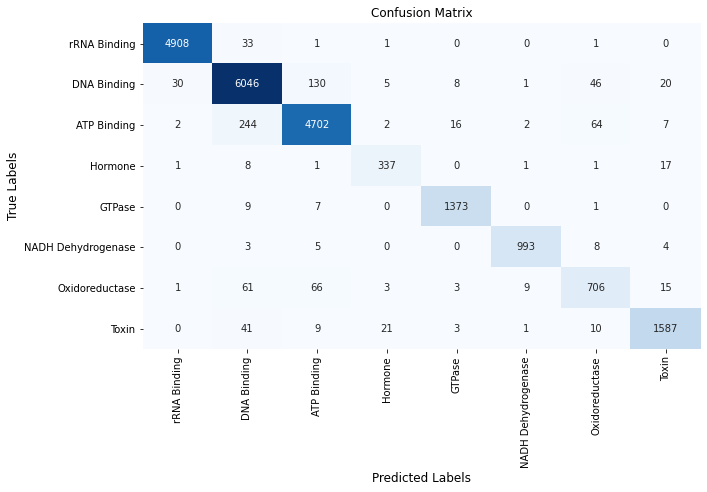

In [ ]:
#create a confusion matrix
confusion = confusion_matrix(y_test_uncategory, preds)

#plot confusion matrix https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
#fmt = 'g' to suppress scientific notation https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(confusion, annot = True, ax = ax, fmt = 'g', cmap = 'Blues', cbar = False);

label_order = ['rRNA Binding', 'DNA Binding', 'ATP Binding', 'Hormone', 'GTPase', 'NADH Dehydrogenase', 'Oxidoreductase', 'Toxin']

#set the labels
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('True Labels',fontsize=12) 
ax.set_title('Confusion Matrix', fontsize = 12) 
ax.xaxis.set_ticklabels(label_order, rotation = 90)
ax.yaxis.set_ticklabels(label_order, rotation = 0);

# uncomment to save the image locally
#from google.colab import files
#plt.savefig("osamp2_confusion.png", bbox_inches='tight', dpi=300)
#files.download("osamp2_confusion.png")

### Visualization Interpretation

The visualization above is a confusion matrix for the final productio model. The confusion matrix takes the predictions of the models and compares them to the true labels of those predictions. Above, the true and predicted labels for each class are shown. The confusion matrix allows us to see where a large proportion of the misclassifications are occuring within the data. Unsurprisingly, the highest number of misclassifications came from the ATP binding and DNA binding classes. There were protein sequences in modeling which had both of these functions attributed to them. Another area of large portions of misclassifications came from the ATP binding/DNA binding and Oxidoreductase class. 

In [ ]:
#get the classification report for the 2 layer convolutional model
#find out where the misclassifications are occuring in the model
print(classification_report(y_test_uncategory, preds, target_names=label_order))

                    precision    recall  f1-score   support

      rRNA Binding       0.99      0.99      0.99      4944
       DNA Binding       0.94      0.96      0.95      6286
       ATP Binding       0.96      0.93      0.94      5039
           Hormone       0.91      0.92      0.92       366
            GTPase       0.98      0.99      0.98      1390
NADH Dehydrogenase       0.99      0.98      0.98      1013
    Oxidoreductase       0.84      0.82      0.83       864
             Toxin       0.96      0.95      0.96      1672

          accuracy                           0.96     21574
         macro avg       0.95      0.94      0.94     21574
      weighted avg       0.96      0.96      0.96     21574



### Table Interpretation

The table above is the classification report for the final production model. This report breaks down how well the model performed on predicting the individual classes in the testing data. The final production model has the best f1-scores across the board for the Hormone and Oxidoreductase class; scoring .92 and .83, respectively. Every other class, besides Hormone and Oxidoreductase, had f1-scores of .94 and above. 

In [ ]:
#get the balanced accuracy score
balanced_accuracy_score(y_test_uncategory, preds)

0.9428429748657909

In [ ]:
#get the f1-score
f1_score(y_test_uncategory, preds, average = 'weighted')

0.9571748077581367

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

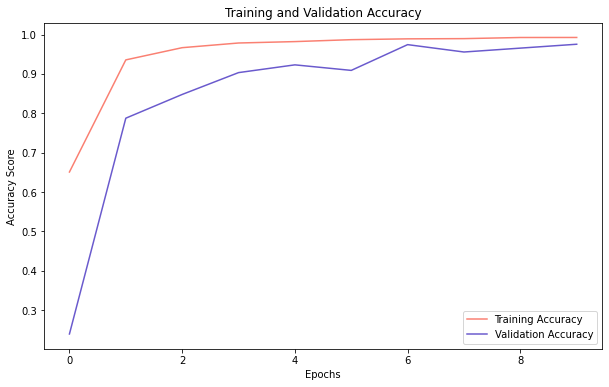

In [ ]:
#plot the graphs of the accuracy
plt.figure(figsize=(10,6))
plt.plot(hist_osamp_2.history['acc'], label = 'Training Accuracy', color = '#FA8072')
plt.plot(hist_osamp_2.history['val_acc'], label = 'Validation Accuracy', color = '#6A5ACD')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend();

#uncomment to save the image locally
#from google.colab import files
#plt.savefig("osamp2_accuracy.png", bbox_inches='tight', dpi=300)
#files.download("osamp2_accuracy.png")

### Visualization Interpretation

The visualization above shows the accuracy for the training and validation data over the 10 epochs the neural network trained. As we can see the training accuracy increased rapidly during weight updating between epoch 1 and 2, then plateaued at approximately 99% accuracy. The validation accuracy increased slower and more variably, before plateauing around 97%. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

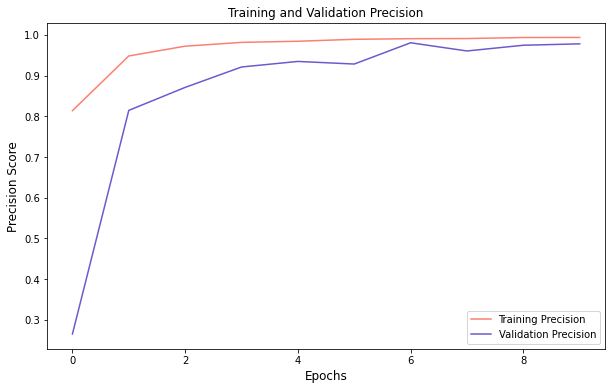

In [ ]:
#plot the graphs of the precision for the convolutional model
plt.figure(figsize=(10,6))
plt.plot(hist_osamp_2.history['precision'], label = 'Training Precision', color = '#FA8072')
plt.plot(hist_osamp_2.history['val_precision'], label = 'Validation Precision', color = '#6A5ACD')
plt.ylabel('Precision Score', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Training and Validation Precision')
plt.legend()

#uncomment to save the image locally
#from google.colab import files
#plt.savefig("osamp2_precision.png", bbox_inches='tight', dpi=300)
#files.download("osamp2_precision.png");

### Visualization Interpretation

The visualization above shows the precision score for the training and validation data over the 10 epochs the neural network trained. As we can see the training precision increased rapidly during weight updating between epoch 1 and 2, then plateaued at approximately 99% accuracy. The validation precision increased slower and more variably, before plateauing around 97%. The accuracy and precision visualization follow an extremely similar path, making the graphs appear identical.